In [24]:
import torch
import open3d as o3d
import numpy as np
import scipy.interpolate as interp
from matplotlib import pyplot as plt
import cv2
import os
from tqdm import tqdm

In [21]:
def affine2D_pc(pc, perp_axis, translation1, translation2, angle, device = 'cpu', invert_affine=False):
    affine_matrix = torch.Tensor([[torch.cos(angle), -torch.sin(angle), translation1],
                                [torch.sin(angle), torch.cos(angle), translation2],
                                [0, 0, 1]]).float().to(device)
    if invert_affine:
        affine_matrix = torch.linalg.inv(affine_matrix)
    non_perp_indices = [0,1,2]
    non_perp_indices.remove(perp_axis)
    pc2d = pc[:, non_perp_indices]
    pcdepth = pc[:, perp_axis]
    pc2d = torch.cat((pc2d, torch.ones((pc2d.shape[0], 1)).to(device)), axis=1)
    pc2d = torch.matmul(affine_matrix, pc2d.T).T
    new_pc = pc.clone()
    new_pc[:, non_perp_indices] = pc2d[:, :2]
    new_pc[:, perp_axis] = pcdepth
    return new_pc

def generate_depth_image(gelslim_plane, plane_axes, mm_per_pixel, image_size, pc, translation1, translation2, angle, inter_gelslim_distance, device = 'cpu', invert_affine=False):
    #use invert_affine=True if translation1, translation2, and angle are the values of the grasp frame with respect to the point cloud frame
    #use invert_affine=False if translation1, translation2, and angle are the values of the point cloud frame with respect to the grasp frame (i.e. "in_hand_pose"), this is the default and compatible with the provided dataset
    #self.plane_axes removes + and - from the gelslim_plane string and returns a list of the characters in the string
    #plane_signs removes the characters in the gelslim_plane string that are not + or - and returns a list of the characters in the string
    plane_signs = [c for c in gelslim_plane if c in ['+', '-']]
    # Truncate the point cloud to the gelslim plane, 1/2 of the gelslim distance from 0 in the perpendicular direction
    if 'x' in plane_axes and 'y' in plane_axes:
        perp_ind = 2
        if plane_axes[0] == 'x' and plane_signs[0] == plane_signs[1]:
            right_out_of_plane_dir = '+z'
            aligned_index = 1
            unaligned_index = 0
        elif plane_axes[0] == 'x' and plane_signs[0] != plane_signs[1]:
            right_out_of_plane_dir = '-z'
            aligned_index = 1
            unaligned_index = 0
        elif plane_axes[0] == 'y' and plane_signs[0] == plane_signs[1]:
            right_out_of_plane_dir = '-z'
            aligned_index = 0
            unaligned_index = 1
        elif plane_axes[0] == 'y' and plane_signs[0] != plane_signs[1]:
            right_out_of_plane_dir = '+z'
            aligned_index = 0
            unaligned_index = 1
    elif 'x' in plane_axes and 'z' in plane_axes:
        perp_ind = 1
        if plane_axes[0] == 'x' and plane_signs[0] == plane_signs[1]:
            right_out_of_plane_dir = '-y'
            aligned_index = 2
            unaligned_index = 0
        elif plane_axes[0] == 'x' and plane_signs[0] != plane_signs[1]:
            right_out_of_plane_dir = '+y'
            aligned_index = 2
            unaligned_index = 0
        elif plane_axes[0] == 'z' and plane_signs[0] == plane_signs[1]:
            right_out_of_plane_dir = '+y'
            aligned_index = 0
            unaligned_index = 2
        elif plane_axes[0] == 'z' and plane_signs[0] != plane_signs[1]:
            right_out_of_plane_dir = '-y'
            aligned_index = 0
            unaligned_index = 2
    elif 'y' in plane_axes and 'z' in plane_axes:
        perp_ind = 0
        if plane_axes[0] == 'y' and plane_signs[0] == plane_signs[1]:
            right_out_of_plane_dir = '+x'
            aligned_index = 2
            unaligned_index = 1
        elif plane_axes[0] == 'y' and plane_signs[0] != plane_signs[1]:
            right_out_of_plane_dir = '-x'
            aligned_index = 2
            unaligned_index = 1
        elif plane_axes[0] == 'z' and plane_signs[0] == plane_signs[1]:
            right_out_of_plane_dir = '-x'
            aligned_index = 1
            unaligned_index = 2
        elif plane_axes[0] == 'z' and plane_signs[0] != plane_signs[1]:
            right_out_of_plane_dir = '+x'
            aligned_index = 1
            unaligned_index = 2
    else:
        raise ValueError('Invalid gelslim_plane')
    if '+' in  right_out_of_plane_dir:
        multiplier = 1
    elif '-' in right_out_of_plane_dir:
        multiplier = -1
    #convention here is angle is about the positive axis in the out of plane direction
    #and that the axis of translation1 and the axis of translation2 follow the right hand rule (their cross product is the out of plane direction)
    #i.e if the right out of plane direction is +z, translation1 is +x, and translation2 is +y, then the angle is about the +z axis, and the right hand rule is followed
    #i.e if the right out of plane direction is -x, translation1 is +y, and translation2 is +z, then the angle is about the +x axis, and the right hand rule is followed
    #i.e if the right out of plane direction is +x, translation1 is +y, and translation2 is +z, then the angle is about the +x axis, and the right hand rule is followed
    #center the point cloud about the origin along the out of plane direction
    out_of_plane_middle = (pc[:, perp_ind].max() + pc[:, perp_ind].min()) / 2
    pc[:, perp_ind] = pc[:, perp_ind] - out_of_plane_middle

    pc = affine2D_pc(pc, perp_ind, translation1*1000, translation2*1000, angle, 'cpu', invert_affine)

    right_pc = (pc[multiplier*pc[:, perp_ind] > 0])
    left_pc = (pc[multiplier*pc[:, perp_ind] < 0])
    right_pc[multiplier*right_pc[:, perp_ind] < multiplier*inter_gelslim_distance / 2, perp_ind] = multiplier*inter_gelslim_distance / 2
    left_pc[multiplier*left_pc[:, perp_ind] > -multiplier*inter_gelslim_distance / 2, perp_ind] = -multiplier*inter_gelslim_distance / 2

    right_pc[:, perp_ind] = -(right_pc[:, perp_ind] - multiplier*inter_gelslim_distance / 2)*multiplier
    left_pc[:, perp_ind] = (left_pc[:, perp_ind] + multiplier*inter_gelslim_distance / 2)*multiplier

    left_pc[:, unaligned_index] = -left_pc[:, unaligned_index]

    min_depth_L = left_pc[:, perp_ind].min()
    min_depth_R = right_pc[:, perp_ind].min()

    sample_points = torch.meshgrid(mm_per_pixel*(torch.arange(image_size[0])-image_size[0]/2), mm_per_pixel*(torch.arange(image_size[1])-image_size[1]/2))

    #reshape the sample_points to be a list of 2D points
    sample_points = torch.stack((sample_points[0].flatten(), sample_points[1].flatten()), axis=1).to(device)

    #DEBUG CHECKPOINT: plot the point clouds as they are generated, set to False to skip
    if False:
        import matplotlib.pyplot as plt
        plt.subplot(1,2,1)
        plt.scatter(right_pc[:, unaligned_index], right_pc[:, aligned_index], c=right_pc[:, perp_ind],s=0.1)
        #add colorbar
        plt.colorbar()
        plt.subplot(1,2,2)
        plt.scatter(left_pc[:, unaligned_index], left_pc[:, aligned_index], c=left_pc[:, perp_ind],s=0.1)
        #add colorbar
        plt.colorbar()
        plt.savefig('point_clouds.png')

    right_depth = torch.from_numpy(interp.griddata(right_pc[:, [unaligned_index, aligned_index]].cpu(), right_pc[:, perp_ind].cpu(), sample_points.cpu(), method='linear')).float().to(device)
    left_depth = torch.from_numpy(interp.griddata(left_pc[:, [unaligned_index, aligned_index]].cpu(), left_pc[:, perp_ind].cpu(), sample_points.cpu(), method='linear')).float().to(device)

    #remove positive values
    right_depth[right_depth > 0] = 0
    left_depth[left_depth > 0] = 0

    #remove values lower than the minimum depth
    right_depth[right_depth < min_depth_R] = min_depth_R
    left_depth[left_depth < min_depth_L] = min_depth_L

    #DEBUG CHECKPOINT: plot the sampled depth points as they are generated, set to False to skip
    if False:
        import matplotlib.pyplot as plt
        plt.subplot(1,2,1)
        plt.scatter(sample_points[:,0], sample_points[:,1], c=right_depth.flatten(),s=0.1)
        plt.colorbar()
        plt.subplot(1,2,2)
        plt.scatter(sample_points[:,0], sample_points[:,1], c=left_depth.flatten(),s=0.1)
        plt.colorbar()
        plt.savefig('sampled_depth.png')
        #import pdb; pdb.set_trace()

    #construct the depth image
    right_depth_image = right_depth.reshape(image_size)
    left_depth_image = left_depth.reshape(image_size)

    #replace nans with 0
    right_depth_image[torch.isnan(right_depth_image)] = 0
    left_depth_image[torch.isnan(left_depth_image)] = 0

    #DEBUG CHECKPOINT: plot the depth images as they are generated, set to False to skip
    if True:
        import matplotlib.pyplot as plt
        plt.subplot(1,2,1)
        plt.imshow(right_depth_image.cpu())
        plt.colorbar()
        plt.subplot(1,2,2)
        plt.imshow(left_depth_image.cpu())
        plt.colorbar()
        # plt.savefig('depth_images.png')

    return right_depth_image, left_depth_image

In [48]:
gelslim_plane = '+y+z'
plane_axes = [c for c in gelslim_plane if c.isalpha()]
image_size = (327,420)
image_height_mm = 12
mm_per_pixel = image_height_mm / image_size[0]

gelsim_path = '/home/samanta/touch2touch/data/test/train_only/gelslims/pattern_05_3_lines_angle_2_data_399.pt'
gelsim_path = '/home/samanta/touch2touch/data/test/train_only/gelslims/pattern_05_3_lines_angle_2_data_1271.pt'
gelsim_data = torch.load(gelsim_path)
translation1 = gelsim_data['y']
translation2 = gelsim_data['x']
angle = gelsim_data['theta']
inter_gelslim_distance = 35

mesh_path = '/home/samanta/depth_anything_v2/metric_depth/dataset/pattern_05_3_lines_angle_2.stl'
pc_sampling = 1e5
pc_scale = 1000
mesh = o3d.io.read_triangle_mesh(mesh_path)
pc = mesh.sample_points_uniformly(int(pc_sampling))
pc = torch.from_numpy(np.array(pc.points).astype(np.float32)).to('cpu')
pc = pc * pc_scale

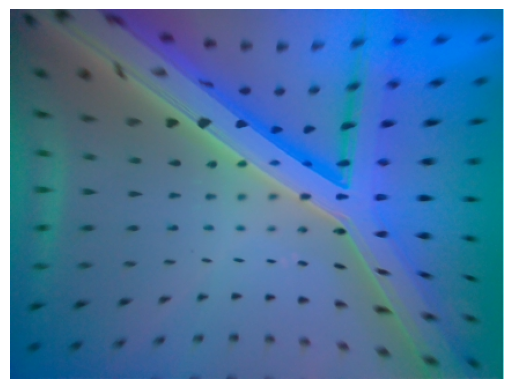

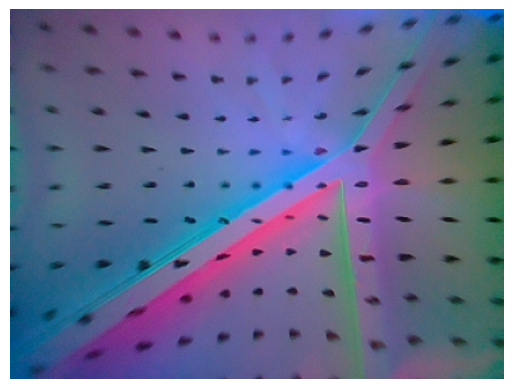

In [49]:
gelslim_image_right = gelsim_data['gelslim'][0].permute(1, 2, 0).numpy()
plt.figure()
plt.axis('off')
gelslim_image_right_vis = (gelslim_image_right - np.min(gelslim_image_right)) / (np.max(gelslim_image_right) - np.min(gelslim_image_right))
# gelslim_image_right_vis = cv2.cvtColor(gelslim_image_right_vis, cv2.COLOR_BGR2RGB)
plt.imshow(gelslim_image_right_vis)

gelslim_image_left = gelsim_data['gelslim'][1].permute(1, 2, 0).numpy()
plt.figure()
plt.axis('off')
gelslim_image_left_vis = (gelslim_image_left - np.min(gelslim_image_left)) / (np.max(gelslim_image_left) - np.min(gelslim_image_left))
# gelslim_image_left_vis = cv2.cvtColor(gelslim_image_left_vis, cv2.COLOR_BGR2RGB)
plt.imshow(gelslim_image_left_vis)

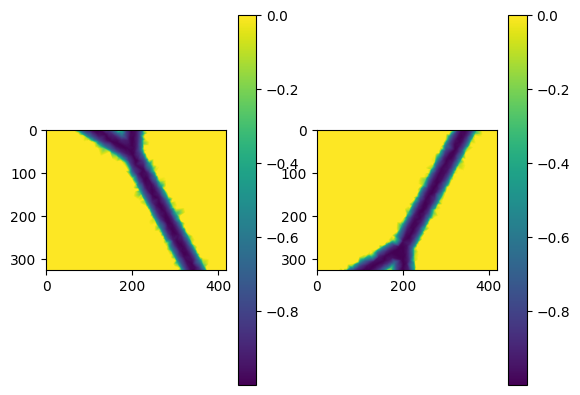

In [50]:
rigth_depth_image, left_depth_image = generate_depth_image(gelslim_plane, plane_axes, mm_per_pixel, image_size, pc, translation1, translation2, angle, inter_gelslim_distance, device = 'cpu', invert_affine=True)